# P1 : Kernel PCA

In [1]:
import scipy.io
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy import exp
import numpy as np
from scipy.linalg import eigh
import scipy.linalg as la
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
concentric = scipy.io.loadmat('concentric.mat')['X']

In [3]:
indexes = []
for i in range(len(concentric[0])):
    each_point = []
    each_point.append(concentric[0][i])
    each_point.append(concentric[1][i])
    indexes.append(each_point)
index = np.array(indexes)

In [4]:
x_conc = concentric[0]
y_conc = concentric[1]

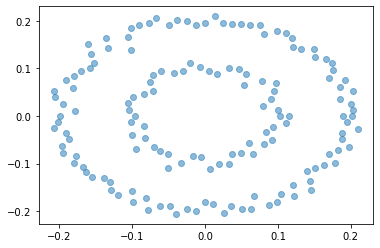

In [5]:
plt.scatter(x_conc,y_conc, alpha=0.5)

Here from the scatter plot we can clearly see 2 clusters - One being the outer big cluster and the other one being the inner cluster.

In [6]:
zeroes = np.zeros(51)
ones = np.ones(index.shape[0]-51)
y_label = np.concatenate((zeroes,ones),axis = 0)

Now lets perform Kernel PCA to change the dimension from 2D to 3D

In [7]:
def RBF(x_1,x_2):
    sig = 0.01
    inner = np.power((x_1 - x_2),2)
    dist_value = np.sum(inner)
    rbf_val = np.exp(-dist_value/sig)
    return rbf_val

In [8]:
def sig(xi):
    return 1/(1 + np.exp(-xi))

In [9]:
term_1 = np.power(concentric[0,:],2)

term_2 = np.power(concentric[1,:],2)

term_3 = concentric[0,:]*concentric[1,:]

term_4 = np.ones(concentric.shape[1])

p_kernel = np.array([term_1,term_2,term_3,term_4])

concentric_shape = concentric.shape[1]

x_kernel = np.array([[RBF(concentric[:,each_1],concentric[:,each_2]) for each_1 in range(concentric_shape)] for each_2 in range(concentric_shape)])

v,w = np.linalg.eig(x_kernel)

In [10]:
weight = np.random.uniform(0,1,size=4).reshape(-1,1)

In [11]:
x = w[:,:1]
y = w[:,1:2]
z = w[:,2:3]

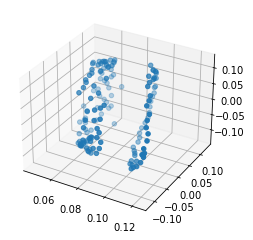

In [12]:
ax = plt.axes(projection='3d')

ax.scatter3D(x,y,z)

In [13]:
eigen_v = w[:,:3].T
rho = 0.01

Now lets implement MLP on top of this data

In [14]:
output_loss = []

eig_shape = eigen_v.shape[1]

term_1 = np.ones(eig_shape).reshape(1,-1)

X_val = np.concatenate((eigen_v, term_1), axis=0)


# Training the network
for i in range(100000):
    
    Z = np.dot(weight.T, X_val)
    
    out_y = sig(Z)
    
    term_dot = np.dot((y_label-out_y),(y_label-out_y).T)
    
    loss_value = term_dot * 0.5
    
    output_loss.append(loss_value)
    
    val = (1 - out_y) * out_y
    
    term_2 = (out_y - y_label) * val
    
    delta_weight = np.dot(X_val,(term_2).T)
    
    weight = weight - (rho * delta_weight)

In [15]:
out_y = sig(np.dot(weight.T, X_val))

loss_dot = np.dot((y_label-out_y),(y_label-out_y).T)

loss = loss_dot * 0.5

loss_fin_val = np.array(output_loss).reshape(100000,1)

print(loss)

[[1.56476605]]


In [16]:
out_y_shape = out_y.shape[1]

pred = np.zeros((out_y_shape))

pred[out_y.squeeze(0) > 0.5] = 1

pred = pred.astype("int")

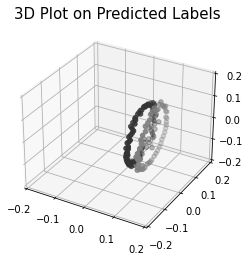

In [17]:
ax = plt.axes(projection='3d')

first=(0.5, 0.5, 0.5, 1.0)
second=(0.2, 0.2, 0.2, 1.0)

col = np.array([first,second])

x_1 = X_val[0,:]
y_1 = X_val[1,:]
z_1 = X_val[2,:]

ax.scatter(xs = x_1, ys = y_1, zs=z_1, c= col[pred])


xx, yy = np.meshgrid(range(-1,1), range(-1,1))
z = (-weight[0] * xx - weight[1] * yy - weight[3]) * 1. /weight[2]


ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.set_zlim(-0.2, 0.2)

plt.title("3D Plot on Predicted Labels", fontdict={'fontsize': 15})
plt.show()




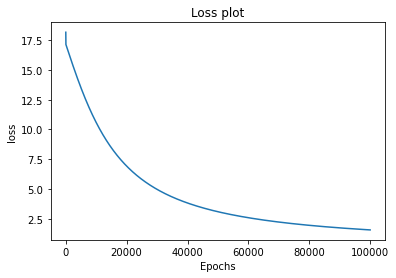

In [18]:
# The below plot is error plot
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title('Loss plot')
plt.plot(loss_fin_val)
plt.show()

# P2: Neural Networks

In [19]:
sum_axis = np.sum(concentric, axis=1)
x = concentric/sum_axis.reshape(-1,1)

In [20]:
zeroes = np.zeros(51)
ones = np.ones(index.shape[0]-51)
y_label = np.concatenate((zeroes,ones),axis = 0)

In [21]:
def sig(xi):
    return 1/(1 + np.exp(-xi))

In [22]:
X = np.concatenate((x, np.ones([1,x.shape[1]])))

In [23]:
def grad_val(rho,w,der_w):
    
    w = w - rho * der_w
    
    return w

In [24]:
np.random.seed(42)

rho = 0.01

weight_1 = np.random.randn(3,3)
weight_2 = np.random.randn(1,4) #weights with bias b2


output = []


for i in range(20000):

    Z1 = np.dot(weight_1, X)

    A1 = sig(Z1)
    
    A1 = np.concatenate((A1, np.ones([1,A1.shape[1]])))

    Z2  = np.dot(weight_2, A1)
    
    out_Y = sig(Z2)
    
    term_1 = out_Y - y_label
    
    term_2 = out_Y*(1 - out_Y)
    
    loss_o = term_1*term_2
    
    derivative_weight_2 = np.dot(loss_o,A1.T)
    
    weight_2 = grad_val(rho,weight_2,derivative_weight_2)
    
    dot_loss = np.dot(weight_2.T,loss_o)

    loss_h = dot_loss*(A1*(1-A1))
    
    derivative_weight_1 = np.dot(loss_h, X.T)[0:3,:]
    
    weight_1 = grad_val(rho,weight_1,derivative_weight_1)
    
    final_dot = np.dot((out_Y-y_label),(out_Y-y_label).T)
    
    loss_f = final_dot * 0.5
    
    output.append(loss_f)


In [25]:
print("loss: ", loss_f)

loss:  [[0.13579416]]


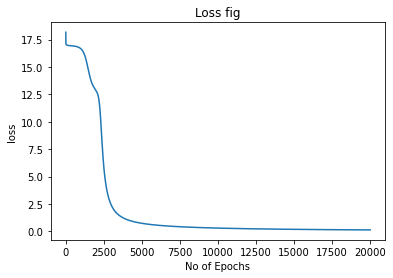

In [26]:
output = np.array(output).reshape(20000,1)
plt.title('Loss fig')
plt.xlabel("No of Epochs")
plt.ylabel("loss")
plt.plot(output)
plt.show()

In [27]:
test_Z1 = np.dot(weight_1, X)

test_A1 = sig(test_Z1)

test_A1 = np.concatenate((test_A1, np.ones([1,test_A1.shape[1]])))

test_Z2  = np.dot(weight_2, test_A1)

final = sig(test_Z2)

final_shape = final.shape[1]

pred = np.zeros((final_shape))

pred[final.squeeze(0) > 0.5] = 1

pred = pred.astype("int")

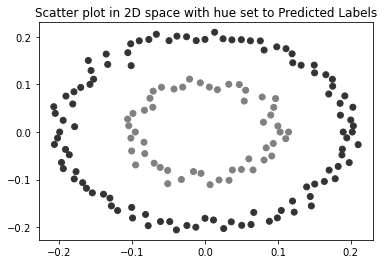

In [28]:
#plot 2d scatter plot
plt.title('Scatter plot in 2D space with hue set to Predicted Labels')
color1=(0.5, 0.5, 0.5, 1.0)
color2=(0.2, 0.2, 0.2, 1.0)
diag_col = np.array([color1,color2])
plt.scatter(concentric[0,:], concentric[1,:],c = diag_col[pred])
plt.show()

# P3: Spoken MNIST

In [29]:
import os
from tqdm import tqdm
import librosa
from hmmlearn.hmm import GMMHMM

In [30]:
directory = 'Jakobovski-free-spoken-digit-dataset-e9e1155/recordings/'

In [31]:
data = []
for each in os.listdir(directory):
    if "jackson" in each:
        data.append(each)

In [32]:
testdata_x = []
testdata_y = []
testdata_t = []
fit_mod = []


digit = []
for each_class in data:
    digit.append(each_class.split('_')[0])
    

In [33]:
hop_val = 512
iter_val = 500
range_num = 45

for each in tqdm(range(10)):
    
    dem_file = []
    
    var = zip(data, digit)
    
    val_t = []
    
    val_x = []
    
    x_testclass = []
    t_testclass = []
    y_testclass = []
    
    for each_1, each_2 in var:
        
        if int(each_2) == each:
            
            dem_file.append(each_1)
    
    for num in range(range_num):
        
        file = directory + dem_file[num]
        
        audio_data, sr = librosa.load(file)
        
        lib_out = librosa.feature.mfcc(audio_data, sr, hop_length=hop_val)
        
        lib_shape = lib_out.shape[1]
        
        val_t.append(lib_shape)
        
        val_x.append(lib_out.T)

    X = np.concatenate(val_x)
    
    Y = [] 
    
    for k in range(range_num):
        
        Y.append(each)

    gmm = GMMHMM(n_components = 5, n_iter = iter_val, random_state = 1)

    gmm.fit(X, val_t)
    
    fit_mod.append(gmm)
    
    
    
    for num in range(5):
        
        file_inner = directory + dem_file[range_num+num]
        
        audio_data, sr = librosa.load(file_inner)
        
        mat_mf = librosa.feature.mfcc(audio_data, sr=sr, hop_length=hop_val)
        
        mat_mf_shape = mat_mf.shape
        
        t_testclass.append(mat_mf_shape[1])
        x_testclass.append(mat_mf.T)
        y_testclass.append(each)
        
    testdata_x.append(np.concatenate(x_testclass))
    testdata_t.append(t_testclass)
    testdata_y.append(y_testclass)

100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


In [34]:
output = []

for each in range(len(testdata_x)):
    
    each_score = []
    
    for each_model in fit_mod:
        
        val = each_model.score(testdata_x[each], testdata_t[each])
        
        each_score.append(val)
    
    output.append(each_score)
    
pred_values = []
    
for pred in output:
    
    pred_values.append(np.argmax(pred))

matrix = np.zeros((10, 10))

for each_1 in range(10):
    
    for each_2 in range(len(pred_values)):
        if each_1 == pred_values[each_2]:
            matrix[each_1][each_2] = 1

In [35]:
matrix

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

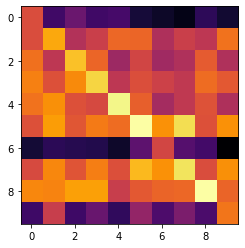

In [36]:
final_val = np.array(output)
plt.imshow(final_val, cmap='inferno')
plt.show()

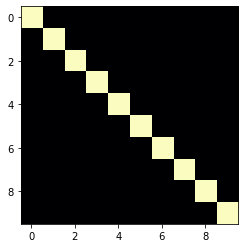

In [37]:
plt.imshow(matrix, cmap='magma')
plt.show()

We can clearly see that diagonal elements has the maximum value in each row
